#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px;"> Advertising Analysis of a Grocery Store Retailer</p>

I analyze a national grocery retailer's household-level transaction history, and I make conclusions that would aid the retailer's advertising efforts. 

* I performed a customer segmentation that identified four distinct clusters based on purchasing patterns. The highest-spending customers are primarily two-adult households with a higher typical income at \\$87,000. The lowest-spending but highest-growth customers tend to be younger adults with a lower typical income at \\$42,000. The retailer will likely gain the most returns by investing in more advertising to the lowest-spending but highest-growth cluster, to ensure they continue increasing their spending. 

* Marketing campaigns using coupons have positive effects even after the campaign is over. Sales are boosted for 30 days, and 20% of households re-buy products that they tried for the first time using a coupon. 

* Product displays in special locations, like in-store or in the weekly mailer, boost sales by a factor of 3.66 on average. The featured products continue to be bought at an elevated rate for almost 60 days. The highest value display locations are the store front, with a 7-times boost in sales and the front-page of the weekly mailer, with a 6.5-times boost in sales. 

I use a data set provided by the data science company Dunhumby. It includes household-level transactions of twenty-five-hundred households over a two-year time frame, at a national grocery retailer. 

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">IMPORTING DATA AND LIBRARIES</p>

In [1]:
# Library imports 
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read in dataframes 
filenames = ["campaign_desc", "campaign_table", "causal_data", "coupon_redempt", "coupon", "hh_demographic",
             "product", "transaction_data"]
df = {filename: pd.read_csv(filename + ".csv") for filename in filenames}

**Description of each dataframe**

**SALE INFORMATION - transactions and products**
* **transaction_data**: all products purchased by all households in study<br>
Columns: HOUSEHOLD_KEY, BASKET_ID (id for purchase), STORE_ID, DAY, PRODUCT_ID, QUANTITY (number of the given product purchased during the trip), SALES_VALUE (amount of dollars retailer receives from sale), COUPON_MATCH_DISC (discount applied due to retailer's match of manufacturer's coupon), COUPON_DISC (discounted applied due to manufacturer coupon), RETAIL_DISC (Discount applied due to retailer's loyalty card program), TRANS_TIME (time when transaction occurred), WEEK_NO (ranges from 1 to 102). 
* **product**: information on each product sold
Index: PRODUCT_ID<br>
Columns: DEPARTMENT (group of similar products), COMMODITY_DESC (group of simlar products, lower level), SUB_COMMODITY_DESC (groups similar products, lowest level), MANUFACTURER, BRAND, CURR_SIZE_OF_PRODUCT (package size, has missing values)

**BUYER INFORMATION - household demographics**
* **hh_demographic**: demographics for a portion of all households. <br>
Index: household_key<br>
Columns: AGE_DESC (estimated age range), MARITAL_STATUS_CODE, INCOME_DESC (household income), HOMEOWNER_DESC, HH_COMP_DESC (household composition), HOUSEHOLD_SIZE_DESC (size of household up to 5+), KID_CATEGORY_DESC (number of children, up to 3+)

**MARKETING CAMPAIGNS (COUPONS)**
* **campaign_desc**: gives the length of time for which a campaign has run. <br>
Index: CAMPAIGN (campaign ID from 1 to 30)<br>
Columns: DESCRIPTION (type of campaign, a, b, or c), START_DAY, END_DAY
* **campaign_table**: lists the campaigns received by each household. <br>
Columns: HOUSEHOLD_KEY (household ID), CAMPAIGN (campaign ID from 1 to 30)
* **coupon_redempt**: lists what household used what coupon, which campaign the coupon came from, and when the coupon was used<br>
Columns: HOUSEHOLD_KEY, CAMPAIGN (campaign ID from 1 to 30), COUPON_UPC (uniquely identifies coupon, for a specific household and campaign), DAY (day of transaction)
* **coupon**: lists all coupons sent out for each campaign, including coupon id and corresponding product ids<br>
Columns: CAMPAIGN (campaign ID from 1 to 30), COUPON_UPC (coupon id, unique to campaign and household), PRODUCT_ID

**ADVERTISEMENTS IN STORE OR WEEKLY MAILER**
* **causal_data**: lists whether a specific product was featured in weekly mailer or in-store display <br>
Columns: PRODUCT_ID, STORE_ID, WEEK_NO (week in which product was featured), DISPLAY (special display location in store), MAILER (display location in weekly mailer) 

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">CUSTOMER SEGMENTATION</p>

We first create a dataframe 'household_df' that carries demographic information and spending patterns for all households for whom this data is available. 
We do this in the hidden code blocks below. 

In [4]:
# Create dataframe 'household_demographic' --- a cleaned up version of df["hh_demographic"], containing demographic information on each household
household_demographic = df["hh_demographic"].copy()

# Drop columns with too many unknowns. Without knowing *why* there are many unknowns, the unknowns could cause us to have a false understanding of the households. 
household_demographic.drop(["MARITAL_STATUS_CODE", "HOMEOWNER_DESC"], axis = 1, inplace = True)

# Create new column: ADULT_COUNT
household_demographic["ADULT_COUNT"] = household_demographic.loc[:, "HH_COMP_DESC"].apply(lambda s:
                                                  (np.nan if "Unknown" in s else 
                                                   (2 if "2" in s else 1)))

# Code below cleans up column 'KID_CATEGORY_DESC' --- But I do not use it because there turn out to be too many nan's. 
# for index in household_demographic.loc[household_demographic["KID_CATEGORY_DESC"] == 'None/Unknown'].index:
#     if "No Kids" in household_demographic.loc[index, "HH_COMP_DESC"]:
#         household_demographic.loc[index, "KID_CATEGORY_DESC"] = 0
#     else:
#         household_demographic.loc[index, "KID_CATEGORY_DESC"] = np.nan
# household_demographic.KID_CATEGORY_DESC.replace({"1": 1, "2": 2, "3+": 3}, inplace = True)
## Use HOUSEHOLD_SIZE_DESC to correct '3' in KID_CATEGORY_DESC to 4, if appropriate
# for index in df["hh_demographic"].loc[
#     (df["hh_demographic"].HOUSEHOLD_SIZE_DESC == '5+') & (df["hh_demographic"].KID_CATEGORY_DESC == 3) \
#     & (df["hh_demographic"].ADULT_COUNT == 1)].index:
#     df["hh_demographic"].loc[index, "KID_CATEGORY_DESC"] = 4
household_demographic.drop(['KID_CATEGORY_DESC', "HH_COMP_DESC", "HOUSEHOLD_SIZE_DESC"], axis = 1, inplace = True)

# Replace Age Range with Middle Value 
AgeRangeDict = {'65+': 70, '55-64': 60, '45-54': 50, '35-44': 40, '25-34': 30, '19-24': 20}
household_demographic.AGE_DESC.replace(AgeRangeDict, inplace = True)

# Clean INCOME_DESC
IncomeRangeDict = {'250K+': 275, 'Under 15K': 10}
income_ranges = df["hh_demographic"].INCOME_DESC.unique()
for s in income_ranges:
    if '-' in s:
        a, b = s[:-1].split('-')
        IncomeRangeDict[s] = (int(a) + int(b)) // 2
household_demographic.INCOME_DESC.replace(IncomeRangeDict, inplace = True)

# Rename columns
household_demographic.rename(columns = {"INCOME_DESC": "INCOME_APPROX", "AGE_DESC": "AGE_APPROX"}, inplace = True)

# Set index to household_key
household_demographic.set_index("household_key", inplace = True)

In [6]:
# Create dataframe 'household_df' to carry information we need to characterize households based on demographics + spending patterns
household_df = household_demographic.copy()

# Create column 'spending_total': total amount spent by household
household_df["spending_total"] = df["transaction_data"].groupby("household_key").SALES_VALUE.sum().loc[household_df.index]

# Create column 'num_baskets': total number of baskets by household
household_df['num_baskets'] = df["transaction_data"].groupby("household_key").BASKET_ID.nunique().loc[household_df.index]

# Create columns for total spending (by household) in each department - "GROCERY", "PRODUCE", "MEAT", "DRUG GM", "KIOSK-GAS"
key_departments = ["GROCERY", "PRODUCE", "MEAT", "DRUG GM", "KIOSK-GAS"] # contain 84% of all spending 
spending_by_department = df["transaction_data"].merge(df["product"][["DEPARTMENT", "PRODUCT_ID"]], on = "PRODUCT_ID", how = "inner")\
    .groupby(["household_key", "DEPARTMENT"]).SALES_VALUE.sum().rename("Sales_Total")\
    .reset_index().set_index("household_key")\
    .pivot(columns = "DEPARTMENT", values = "Sales_Total")\
    .loc[:, key_departments]
household_df = pd.concat([household_df, spending_by_department.loc[household_df.index]], axis = 1)

# Create columns to trends in total spending (by household) in each department. 
#      Trend is defined by coefficient of linear fit of spending versus time. 
max_day = 711
for department in key_departments:
    household_df.insert(len(household_df.columns), 'trend_' + department, value = np.nan)
spending = df["transaction_data"].merge(df["product"][["DEPARTMENT", "COMMODITY_DESC", "PRODUCT_ID"]], on = "PRODUCT_ID", how = "inner")\
        .groupby(["household_key", "DEPARTMENT", "DAY"]).SALES_VALUE.sum()\
        .reset_index().set_index(["household_key", "DEPARTMENT"])
for household_key in household_df.index:
    for department in key_departments:
        if (household_key, department) in spending.index:
            data = spending.loc[(household_key, department)].reset_index().set_index("DAY").reindex(range(1, max_day + 1)).fillna(0.0)[["SALES_VALUE"]].iloc[100:]
            if data.mean()[0] == 0:  continue
            data /= data.mean()
            model = LinearRegression()
            model.fit(data.index.to_numpy().reshape(-1,1), data.values)
            household_df.loc[household_key, 'trend_' + department] = model.coef_[0][0]

In [3146]:
household_df.head()

AGE_APPROX  INCOME_APPROX  ADULT_COUNT  spending_total  \
household_key                                                           
1                      70             42          2.0         4330.16   
7                      50             62          2.0         3400.05   
8                      30             29          2.0         5534.97   
13                     30             87          2.0        13190.92   
16                     50             62          1.0         1512.02   

               num_baskets  GROCERY  PRODUCE    MEAT  DRUG GM  KIOSK-GAS  \
household_key                                                              
1                       86  2755.00   266.10   17.91   530.89        NaN   
7                       59  1901.30   267.04  189.71   652.87        NaN   
8                      113  3107.22   337.98  316.92   778.89     188.94   
13                     275  4925.62   306.92   19.13  2876.38    3205.09   
16                      98   823.76    87.45   95.79    68.29     192.30   

               trend_GROCERY  trend_PRODUCE  trend_MEAT  trend_DRUG GM  \
household_key                                                            
1                  -0.000097       0.000147   -0.005292       0.000956   
7                   0.003624       0.003328    0.001205       0.000468   
8                   0.001298       0.003552    0.000827      -0.001114   
13                  0.000446       0.001313   -0.006140      -0.000775   
16                 -0.003563      -0.003247   -0.004181      -0.003833   

               trend_KIOSK-GAS  
household_key                   
1                          NaN  
7                          NaN  
8                    -0.000992  
13                   -0.000108  
16                   -0.003697

I will apply PCA and KMeans clustering on these 801 households based on spending patterns alone, while excluding demographic information. By doing so, we can see how distinct groups of customers interact with the retailer, and then we can analyze who these groups are by looking into each cluster's demographic breakdown. 

In the code block below, I normalize each feature for household spending patterns, and then apply PCA. 

In [3147]:
# Get portion of dataframe that contains only features about spending patterns
spending_patterns = household_df.loc[:, "spending_total":].fillna(0.0)

# Remove mean and Scale to unit variance 
scaler = StandardScaler()
scaled_spending_patterns = scaler.fit_transform(spending_patterns)

# PCA 
pca = PCA()
pca_spending_patterns = pca.fit_transform(scaled_spending_patterns)

We plot a heatplot showing how the PCA components depend on each spending feature. The PCA components in higher rows correspond to those that have the largest variance among customers, thereby differentiating key customer segments. 
Here are some key features of the top PCA components:
* 1st PCA component: How much customers are spending overall 
* 2nd PCA component: Whether customers are spending more or less over time 
* 3rd PCA component: Whether customers are buying a lot of gasoline and buying more gasoline over time 

We should expect some of these key features (overall spending, trends in spending, etc.) to take a major role in identifying the clusters from KMeans clustering, 
because they account for a significant amount of the variance among households. 

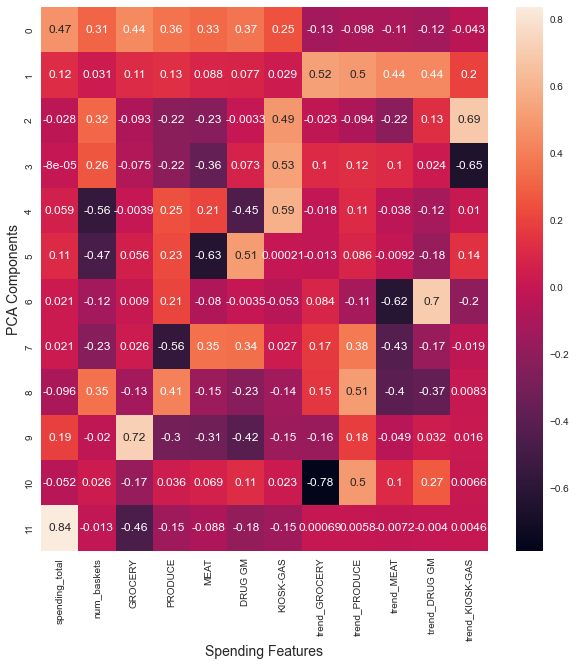

In [3148]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
sns.heatmap(pd.DataFrame(pca.components_, columns = spending_patterns.columns), annot = True)
plt.ylabel("PCA Components", fontsize = 14)
plt.xlabel("Spending Features", fontsize = 14)
plt.show()

Now we can form our customer segments using KMeans Clustering. I will add the cluster label to the 'household_df' dataframe. 

The number of clusters we use is somewhat arbitrary. While the standard 'elbow method' signals that 6 is an optimal number of clusters, it is also too many to be easily interpreted. I find through trial-and-error that the 4 clusters strikes a balance between sufficient segmentation and interpretability.

In [3150]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(pca_spending_patterns)
household_df["clusters"] = kmeans.labels_

In the plots below, I show the households distributions of various spending-features, with each curve corresponding to a different cluster. 
* The first set of five plots shows the distributions of total amounts spent in each department
* The second set of five plots shows the distributions of *trends* in the amounts spent in each department. These trend values are positive if the household spent more money in the department over time -as the two years of data collection passed- or negative if they spent less over time. 

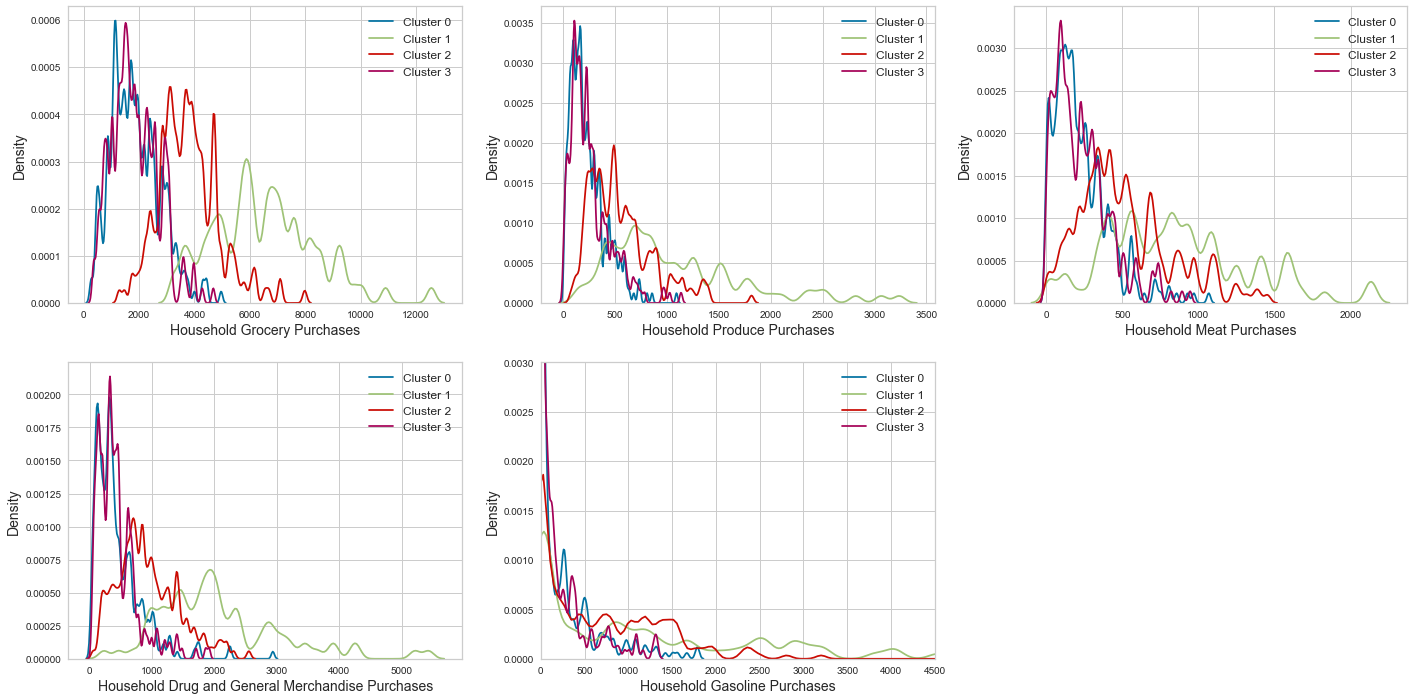

In [3151]:
fig, axes = plt.subplots(2,3,figsize = (24,12))
fig.delaxes(axes[1][2])

axis_dict = {0: axes[0][0], 1: axes[0][1], 2: axes[0][2], 3: axes[1][0], 4: axes[1][1]}
xlabel_dict = {0: 'Household Grocery Purchases', 1: 'Household Produce Purchases', 2: 'Household Meat Purchases', 
               3: 'Household Drug and General Merchandise Purchases', 4: 'Household Gasoline Purchases'}
for plot_no, feature in enumerate(['GROCERY', 'PRODUCE', 'MEAT', 'DRUG GM', 'KIOSK-GAS']):
    # Define where to place plot
    ax = axis_dict[plot_no]
    xlabel = xlabel_dict[plot_no]
    # Make plot for each cluster
    for cluster_no in range(4):
        data = household_df[household_df.clusters == cluster_no][feature].fillna(0.0)
        sns.kdeplot(data, label = 'Cluster ' + str(cluster_no), bw_adjust = 0.2, ax = ax)
    # Tune plot appearance
    ax.set_xlabel(xlabel, fontsize = 14)
    ax.set_ylabel("Density", fontsize = 14)
    ax.legend(fontsize = 12)
# More of tuning plot appearances
axes[1][1].set_ylim(0, 0.003)
axes[1][1].set_xlim(0, 4500)
plt.show()

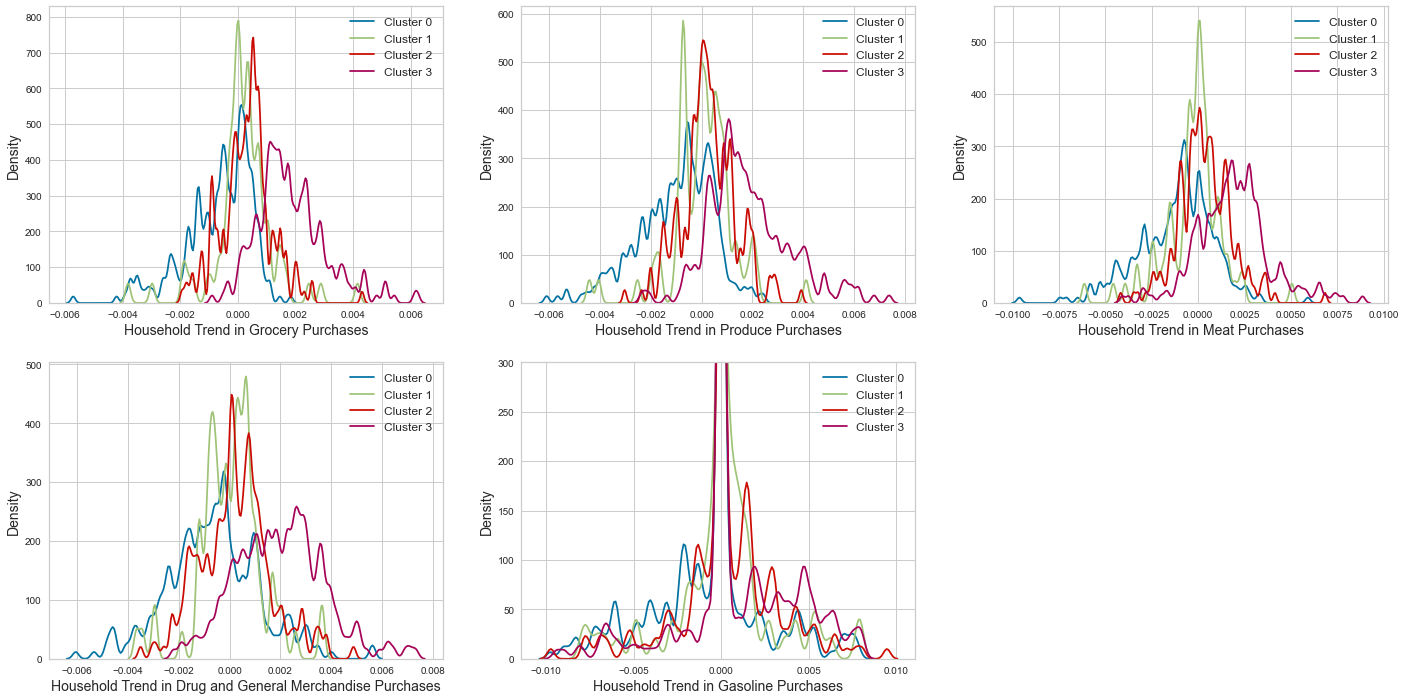

In [3153]:
fig, axes = plt.subplots(2,3,figsize = (24,12))
fig.delaxes(axes[1][2])

axis_dict = {0: axes[0][0], 1: axes[0][1], 2: axes[0][2], 3: axes[1][0], 4: axes[1][1]}
xlabel_dict = {0: 'Household Trend in Grocery Purchases', 1: 'Household Trend in Produce Purchases', 2: 'Household Trend in Meat Purchases', 
               3: 'Household Trend in Drug and General Merchandise Purchases', 4: 'Household Trend in Gasoline Purchases'}
for plot_no, feature in enumerate(['trend_GROCERY', 'trend_PRODUCE', 'trend_MEAT', 'trend_DRUG GM', 'trend_KIOSK-GAS']):
    # Define where to place plot
    ax = axis_dict[plot_no]
    xlabel = xlabel_dict[plot_no]
    # Make plot for each cluster
    for cluster_no in range(4):
        data = household_df[household_df.clusters == cluster_no][feature].fillna(0.0)
        sns.kdeplot(data, label = 'Cluster ' + str(cluster_no), bw_adjust = 0.2, ax = ax)
    # Tune plot appearance
    ax.set_xlabel(xlabel, fontsize = 14)
    ax.set_ylabel("Density", fontsize = 14)
    ax.legend(fontsize = 12)
# More tuning of plot appearances
axes[1][1].set_ylim(0, 300)
plt.show()

According to the plots above, the key distinctions in spending patterns between clusters are:
* Cluster 1: Highest spenders. Spending rate is stagnant. 
* Cluster 2: Moderately high spenders. Spending rate is stagnant. 
* Cluster 3: Low spenders. High potential because spending is increasing over time. 
* Cluster 0: Low spenders. Low potential because spending is stagnant or decreasing over time. 

For the purposes of differentiating between clusters, the relative spending in different departments (ex. groceries versus gasoline) are not relevant. It looks like spending (or trends in spending) in any department is positively correlated with spending (or trends in spending) in another department, so I will just focus on overall spending when discussing the clusters.

Let's now see who these clusters are, according to the demographic features we have: 
* Number of Adults in Household
* Approximate Age
* Approximate Income

See the plots below for how our customer segments differ in demographics.

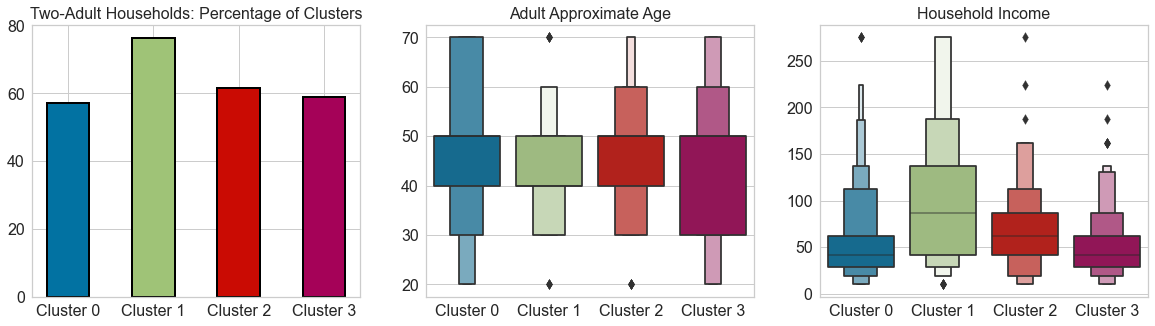

In [3229]:
fig, axes = plt.subplots(1,3, figsize = (20,5))

# Bar plot: percentage of two adult households 
axes[0].bar(
    ['Cluster ' + str(cluster) for cluster in range(4)],
    [100 * household_df[household_df.clusters == cluster].ADULT_COUNT.dropna().value_counts()[2] / household_df[household_df.clusters == cluster].ADULT_COUNT.dropna().shape[0]\
     for cluster in range(4)],
    color = sns.color_palette()[:4],
    edgecolor = 'black',
    width = 0.5,
    lw = 2
)

# Box plots 
for plot_no, feature in enumerate(["AGE_APPROX", "INCOME_APPROX"]):
    sns.boxenplot(data = household_df, x = 'clusters', y = feature, ax = axes[plot_no + 1])
    
# Plot appearance
axes[0].set_title('Two-Adult Households: Percentage of Clusters', fontsize = 16)
axes[1].set_title('Adult Approximate Age', fontsize = 16)
axes[2].set_title('Household Income', fontsize = 16)
for i, axis in enumerate(axes):
    axis.tick_params(axis='both', which='major', labelsize=16)
    if i != 0: # avoid a warning 
        axis.set_xticklabels(['Cluster ' + str(cluster) for cluster in range(4)])
    axis.set_xlabel('')
    axis.set_ylabel('')
    
plt.show()

Now we know more about who each cluster represents. 

**Highest-Value Customers (10% of households, Cluster 1)** 
* Highest Spenders
* Stagnant Spenders: spending is not changing over time
* Majority two-adult households
* Highest income: median 87K versus median 62K for all households

**High-Value Customers (25% of households, Cluster 2)**
* Moderately high spenders
* Stagnant Spenders
* Average income: median 62K 

**Low-Value, High-Growth Customers (30% of households, Cluster 3)**
* Low spenders
* Increasing spenders: spending is increasing over time
* Includes more young people (ages 20-30) than previous two clusters. 
* Lowest income: median 42K

**Low-Value, Low-Growth Customers (35% of households, Cluster 0)**
* Low spenders
* Decreasing spenders: spending is either stagnant or decreasing over time 
* Includes more old people (ages 60+) than any other cluster. 
* Average income: median 42K 

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">MARKETING CAMPAIGN ANALYSIS</p>

The retailer has run a number of marketing campaigns, defined by sending coupons to households to encourage purchasing specific products. Out of all the marketing campaigns, one type had by far the most participation: a personalized, unique set of 16 coupons was sent to each household based on what the retailer thought each household would be most interested in. 

We want to know how effective these marketing campaigns are. Specifically, we will address these questions:
* What is the household participation rate? Are some segments more likely to participate than others? 
* How does participation rate evolve over the lifetime of a campaign? Do more or fewer people use coupons as the campaign nears its end? 
* Of households that try a product for the first time with a coupon: how likely are they to buy the product again, after the marketing campaign is over?
* Of households that used a coupon for a product they were familiar with: do they buy the product even more often, after the marketing campaign is over?

In [8]:
# Participation in most campaigns, among households with recorded data, is extremely low. Let's restrict to campaigns that have at least 100 redeemed coupons. 
campaigns_lst = [8, 13, 18]

# Add a new column to 'household_df': the number of coupons used 'NumCouponsUsed'
household_coupons_df = household_df.merge(
    df["coupon_redempt"][df["coupon_redempt"].CAMPAIGN.isin(campaigns_lst)].groupby('household_key').size().rename('NumCouponsUsed'),
    on = 'household_key',
    how = 'left')
household_coupons_df.NumCouponsUsed.fillna(0, inplace = True)

# What percentage of households participated at all? 
hh_offered = set(household_coupons_df.index).intersection( set(df["campaign_table"].household_key) )
household_coupons_df = household_coupons_df.loc[hh_offered]
n_participated = sum(household_coupons_df.NumCouponsUsed != 0)
n_offered = household_coupons_df.shape[0] 
print('{:.0f}% of households participated in a marketing campaign at least once.'.format(100 * n_participated / n_offered))

35% of households participated in a marketing campaign at least once.


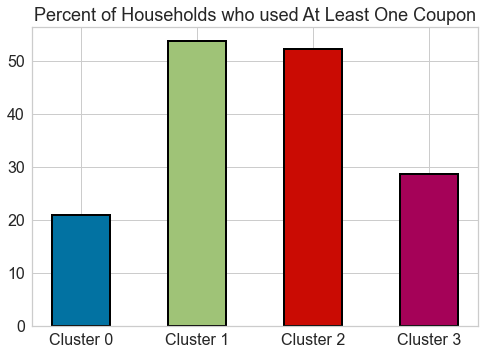

In [3376]:
plt.bar(['Cluster ' + str(cluster) for cluster in range(4)], 
        100 * household_coupons_df[household_coupons_df.NumCouponsUsed != 0].groupby('clusters').size() / household_coupons_df.groupby('clusters').size(),
       color = sns.color_palette()[:4],
        edgecolor = 'black',
        width = 0.5,
        lw = 2)
plt.title('Percent of Households who used At Least One Coupon', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

From highest participation to lowest participation are: Cluster 1 (highest spenders), Cluster 2 (moderately high spenders), Cluster 3 (low-spending, high-potential),
and Cluster 4 (low-spending, low-potential). It seems that how much money a household spends overall is a significantly stronger predictor for coupon usage than income or any other demographic feature we have access to. After all, Cluster 1 and 2 use coupons almost as often, even though Cluster 1 has a drastically higher household income than all other groups. 

In the plot below, we see that participation rates in the marketing campaigns drops significantly over time. A month into each campaign, coupon redemptions drop by over half. 

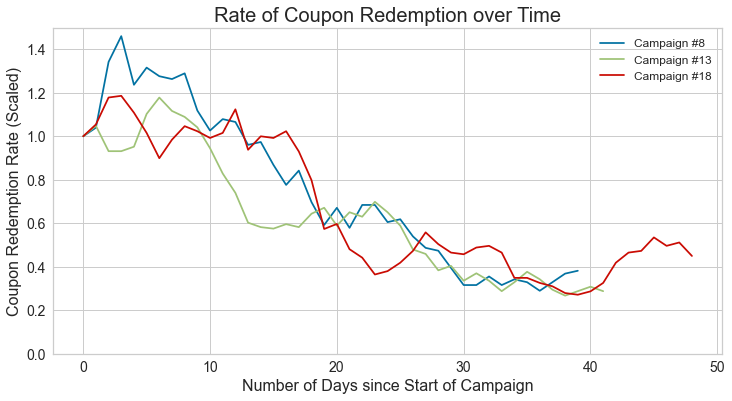

In [3425]:
# Rate of Coupon Redemption over Time, during campaign
fig, ax = plt.subplots(1,1,figsize = (12,6))

for campaign in campaigns_lst:
    rates_of_redemption = list(df["coupon_redempt"][df["coupon_redempt"].CAMPAIGN == campaign].groupby("DAY").size().rolling(7).mean().dropna())
        # 7-day rolling averages for number of coupons, for the specified campaign, redeemed per day
    scaled_rates = [x / rates_of_redemption[0] for x in rates_of_redemption]
        # scale coupon redemption rates to start at 1 
    plt.plot(
        range(len(scaled_rates)),
        scaled_rates,
        label = "Campaign #" + str(campaign)
    )
plt.ylabel("Coupon Redemption Rate (Scaled)", fontsize = 16)
plt.xlabel("Number of Days since Start of Campaign", fontsize = 16)
plt.title("Rate of Coupon Redemption over Time", fontsize = 20)
plt.legend(fontsize = 12)
plt.ylim(0, 1.5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

Given that a household buys a product with a coupon, are they likely to buy the product more often after the marketing campaign, without any coupon? 

In [10]:
# Get 'transactions_coupons' - all transactions that used coupons
transactions_coupons = df["transaction_data"][(df["transaction_data"].COUPON_DISC != 0) | (df["transaction_data"].COUPON_MATCH_DISC != 0)]

# Attach information on which coupon was applied, from what campaign
transactions_coupons = transactions_coupons.merge(
    df["coupon_redempt"].merge(df["coupon"][["COUPON_UPC", "PRODUCT_ID"]], on = "COUPON_UPC", how = "inner"), 
        # each row corresponds to a household that redeemed a coupon on a specific day. 
        # an extra column added here, 'product_id', accounts for all products that the coupon *COULD* have been applied to. 
        # but we don't know which product that is until we do the outer-merging with 'transactions_coupons'. 
    on = ["household_key", "DAY", "PRODUCT_ID"], how = "inner")

# Restrict to transactions involving coupons from the campaigns under study: 8, 13, 18. 
transactions_coupons = transactions_coupons.loc[transactions_coupons.CAMPAIGN.isin(campaigns_lst)]

# Get all transactions involving any (household, product) which was purchased with a coupon at ANY time 
transactions_coupons = df["transaction_data"].merge(
    transactions_coupons[["household_key", "PRODUCT_ID", "BASKET_ID", "DAY", "CAMPAIGN"]]\
        .rename({"BASKET_ID": "BASKET_ID_COUPON", "DAY": "DAY_COUPON_USAGE"}, axis = 1),
    on = ["household_key", "PRODUCT_ID"],
    how = "inner")

# Get campaign start and end days 
transactions_coupons = transactions_coupons.merge(
    df["campaign_desc"][["START_DAY", "END_DAY"]]\
        .rename({"START_DAY": "CAMPAIGN_START", "END_DAY": "CAMPAIGN_END"}, axis = 1), 
    left_on = "CAMPAIGN", right_index = True,
    how = "inner")

In [11]:
# Of those (household, product) who had bought BEFORE campaign started: how did the sales boost change AFTER the campaign ended?  
before_campaign = pd.concat([
    transactions_coupons[(transactions_coupons.DAY < transactions_coupons.CAMPAIGN_START)]\
        .groupby(["household_key", "PRODUCT_ID"]).size()\
        .rename("NumSalesBeforeCampaign"),
    transactions_coupons[(transactions_coupons.DAY < transactions_coupons.CAMPAIGN_START)]\
        .groupby(["household_key", "PRODUCT_ID"]).CAMPAIGN_START.first()\
        .rename("DaysBeforeCampaign")
], axis = 1)

periods = [(i, i + 1) for i in range(0, 80)]
sales_boost = []

for start, end in periods: 
    # Number of sales, for each (household, product) bought in period AFTER campaign ended
    after_campaign = transactions_coupons.loc[
            (transactions_coupons.CAMPAIGN_END + start <= transactions_coupons.DAY) & (transactions_coupons.DAY < transactions_coupons.CAMPAIGN_END + end)]\
            .groupby(["household_key", "PRODUCT_ID"]).size()\
            .rename("NumSalesAfterCampaign")
    
    # Keep ONLY the (h,p) that were bought BEFORE campaign started 
    before_after_campaign = before_campaign.merge(after_campaign, left_index = True, right_index = True, how = 'left').fillna(0.0)
    daily_sales_increase = (before_after_campaign.NumSalesAfterCampaign) / (before_campaign.NumSalesBeforeCampaign / before_campaign.DaysBeforeCampaign)
    sales_boost.append(daily_sales_increase.mean())

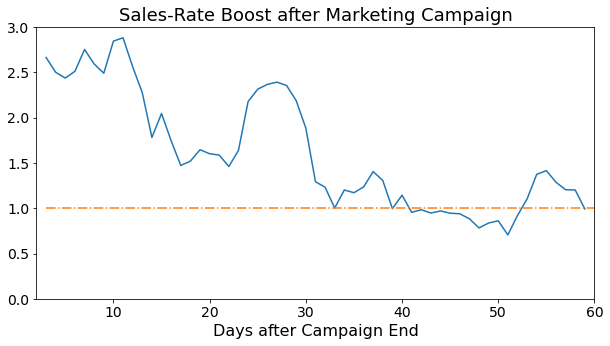

In [43]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.plot(pd.Series(sales_boost).rolling(7, center = True).mean().dropna().iloc[:57], color = 'tab:blue')
plt.plot(range(3, 60 + 1), [1] * (60 + 1 - 3), '-.', color = 'tab:orange')
plt.ylim(0, 3)
plt.xlim(2, 60)
plt.title("Sales-Rate Boost after Marketing Campaign", fontsize = 18) 
plt.xlabel("Days after Campaign End", fontsize = 16) 
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

The plot above shows the multiplicative-sales-rate boost for a household buying a specific product, given that the household bought this product with a coupon during the marketing campaign. I restrict these (household, product) combinations exclusively to the households who had bought the product at least once before the marketing campaign; thus a multiplicative-sales-rate boost is a well-defined quantity. 

We see that there is a significant sales boost for a full month after the marketing campaign is over, indicating that using the coupon during the campaign entices the household to keep buying the same product at full price later on. However, the sales boost drops to about one after a month has passed, showing that the marketing campaign's effects entirely vanish after a month! 

To decide whether the marketing campaigns are in the retailer's benefit, they should consider whether the profit loss due to providing coupons is worth the month-long boost in sales after the campaign is over.

While the plot above depicts the effects of providing a coupon for a product to a household who has *already bought* that product in the past, we also want to see the effects of providing a coupon for a product the household has never bought before. We cannot look at a multiplicative sales rate boost because they had never bought the product before. But instead, we can look at what percent of households buy the product again, after the campaign is over. 

In [3441]:
# all household, product that were bought BEFORE campaign even started 
bought_before = list(transactions_coupons[transactions_coupons.DAY < transactions_coupons.CAMPAIGN_START].groupby(["household_key", "PRODUCT_ID"]).size().index)
all_hp = list(transactions_coupons.groupby(["household_key", "PRODUCT_ID"]).size().index)
not_bought_before = list(set(all_hp) - set(bought_before))

# how many (household, product), never bought before marketing campaign, were bought again within a month of the campaign ending? 
bought_again_in_month = sum(
    transactions_coupons[(transactions_coupons.DAY > transactions_coupons.CAMPAIGN_END) & (transactions_coupons.DAY < transactions_coupons.CAMPAIGN_END + 30)]\
    .groupby(["household_key", "PRODUCT_ID"]).size().index.isin(not_bought_before)
)

print('{:.0f}% of households, who received a coupon for a product they had never bought before, bought the product again within a month'.format(
    100 * bought_again_in_month / len(not_bought_before)))

20% of households, who received a coupon for a product they had never bought before, bought the product again within a month


This statistic suggests it is valuable to send coupons to households for products they have never bought before. It may be a viable strategy to widen the range of products each household is buying from the retailer. 

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">PRODUCTS ON DISPLAY - SALES BOOST</p>

Products are frequently featured in a variety of special locations in-store, or in the retailer's weekly mailer. We would like to know how effective these displays are at increasing sales of the products. Specific questions we will address are:
* How much does featuring a product, by putting it on display, increase sales during and after?
* Which special display locations (like the front end cap of an aisle, or the front page of a mailer) are most effective at increasing sales? 
* What is the effect of featuring a product for multiple consecutive weeks? Does the sales rate boost keep increasing with growing product-recognition? Or does the sales rate boost fall when customers start to ignore the product after seeing it multiple times? 

In [18]:
# Create the new dataframe 'causal_df', to describe what product is featured, where and when. 

min_week = 16 # Transaction data collection was still ramping up before week 16. All data before this must be removed.
max_week = df["transaction_data"].WEEK_NO.max() # Last week of data collection 

# Keep products featured in ONE display location (in a given week)
causal_df = df["causal_data"].loc[(df["causal_data"].display == '0') | (df["causal_data"].mailer == '0')]

# For each (PRODUCT_ID, STORE_ID) combination, get TOTAL_WEEKS_FEATURED in ANY display/mailer location
causal_df = causal_df.merge(causal_df.groupby(["PRODUCT_ID", "STORE_ID"]).size().rename("TOTAL_WEEKS_FEATURED"), on = ["PRODUCT_ID", "STORE_ID"], how = "left")

# Some (PRODUCT_ID, STORE_ID)'s are featured for tens of weeks! Keep ONLY those that are featured for a SINGLE week
causal_df = causal_df.loc[causal_df.TOTAL_WEEKS_FEATURED == 1].drop("TOTAL_WEEKS_FEATURED", axis = 1).copy()

# Clean up data for display location 
causal_df["display_location"] = causal_df\
        .apply(lambda row: "store_" + row["display"] if (row["mailer"] == "0") else ("mailer_" + row["mailer"]),
        axis = 1)
causal_df.drop(["display", "mailer"], axis = 1, inplace = True)

# Add column, WEEKS_BEFORE, counting number of weeks available in transaction data set BEFORE product was featured 
causal_df["WEEKS_BEFORE"] = causal_df["WEEK_NO"] - min_week 

# Throw out any data for products featured <= week 15. Transaction data collection was still ramping up at the time. 
causal_df = causal_df[causal_df["WEEK_NO"] >= min_week]

# Set index, now that each row is uniquely defined by PRODUCT_ID, STORE_ID
causal_df.set_index(["PRODUCT_ID", "STORE_ID"], inplace = True)

In [19]:
# Create the new dataframe 'transactions_displayed': each row refers to a transaction of a (product, store) that was featured at ANY time

# Drop any information on (product, store) combinations that were featured at any time, but never bought, as this is necessarily an artifact of the fact
#    that we're following a limited number of households 
transactions_displayed = df["transaction_data"][["PRODUCT_ID", "STORE_ID", "WEEK_NO"]].rename({"WEEK_NO": "TRANSACTION_WEEK_NO"}, axis = 1)

# Throw out all data for transactions occuring <= week 15. Transaction data collection was still ramping up at the time. 
transactions_displayed = transactions_displayed[transactions_displayed["TRANSACTION_WEEK_NO"] >= min_week]

# Inner join with information on when (product, store) was featured.
transactions_displayed = transactions_displayed.merge(causal_df.rename({"WEEK_NO": "FEATURED_WEEK_NO"}, axis = 1), on = ["PRODUCT_ID", "STORE_ID"], how = "inner")

# Create new column, "WEEK_DIFFERENCE". It is the number of weeks that a purchase occurred, after the (product, store) was featured.
# If the (product, store) was purchased before being featured, WEEK_DIFFERENCE is given the value -1 
transactions_displayed["WEEK_DIFFERENCE"] = transactions_displayed.apply(
        lambda row: (row["TRANSACTION_WEEK_NO"] - row["FEATURED_WEEK_NO"]) if (row["TRANSACTION_WEEK_NO"] >= row["FEATURED_WEEK_NO"]) else -1, axis = 1)

# Create new column, "WEEKS_BEFORE", with number of weeks during which data was being taken, BEFORE a (product, store) is featured.
# We need this column, so that we can compute (Sales before featuring) / (Weeks before featuring), to get average sale rate before (product, store) was featured.
transactions_displayed["WEEKS_BEFORE"] = transactions_displayed.FEATURED_WEEK_NO - min_week 

# Create new column, "MAX_WEEK_DIFFERENCE", with maximum number of weeks that can pass, since (product, store) was featured, before max_week (end of data collection).
transactions_displayed["MAX_WEEK_DIFFERENCE"] = max_week - transactions_displayed["FEATURED_WEEK_NO"] 

In [20]:
salesRates = []
week_limit = 8

# Get salesRateInitial: average weekly sales rate for (product, store), BEFORE being featured. 
# Create dataframe: (Purchases before featuring) -leftmerge- (# of weeks available, from beginning of data collection to when product is featured)
sales_before = transactions_displayed.loc[transactions_displayed.WEEK_DIFFERENCE == -1]\
    .groupby(["PRODUCT_ID","STORE_ID"]).size().rename("TotalSalesBefore").to_frame()\
    .merge(causal_df[["WEEKS_BEFORE"]], on = ["PRODUCT_ID", "STORE_ID"], how = "left")
# salesRateUncorrected - Average weekly sales rate. Does NOT yet include products that were not bought at all before being featured. 
salesRateUncorrected = (sales_before.TotalSalesBefore / sales_before.WEEKS_BEFORE).mean()
# available_count - Total number of (product, store)'s that were featured. 
available_count = transactions_displayed.groupby(["PRODUCT_ID","STORE_ID"]).size().shape[0]
# Rescale salesRateUncorrected to include products not bought before being featured.
salesRateInitial = salesRateUncorrected * (sales_before.shape[0] / available_count)

# For 'weeks' = 0, 1, 2, ... passed since (product, store) was featured: what is the average sales rate? 
for weeks in range(week_limit): 
    available_count = transactions_displayed.loc[transactions_displayed["MAX_WEEK_DIFFERENCE"] >= weeks]\
        .groupby(["PRODUCT_ID","STORE_ID"]).size().shape[0]
    salesRates.append(sum(transactions_displayed["WEEK_DIFFERENCE"] == weeks) / available_count / salesRateInitial)

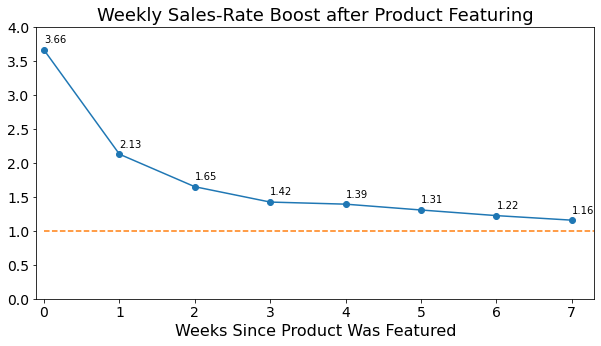

In [32]:
# General sale rates do not change by more than a few percent within 7 weeks. So they are not relevant to the significant boost in sales. 
fig, ax = plt.subplots(1,1, figsize = (10,5))

plt.plot(range(week_limit), salesRates[:week_limit], '-o', c = 'tab:blue')
plt.plot(range(week_limit + 1), [1] * (week_limit + 1), '--', c = 'tab:orange')

for i,j in zip(range(week_limit), salesRates[:week_limit]):
    ax.annotate("{:.2f}".format(j),xy = (i,j + 0.1))
    
plt.ylim(0,4)
plt.xlim(-0.1,7.3)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlabel("Weeks Since Product Was Featured", fontsize = 16) # at a specific store
plt.title("Weekly Sales-Rate Boost after Product Featuring", fontsize = 18)
plt.show()

The plot above shows a large initial increase in sales when a product is placed on display. In making this plot, we restricted to looking only at products that were featured in exactly one place for exactly one week, thereby controlling for any variance in these factors. Products on display sell, on average, at 3.66 times the typical rate before being on display. This effect degrades over time, ultimately falling to 1.39 after a month and nearly 1 after two months. Note that a factor of '1' means that, after two months, having featuring the product has almost no effect on sales. 

The retailer can use the significant sales rate boost to calculate and justify the advertising fee they charge manufacturers for featuring their products in special locations. 

Featuring a product in a special location, in-store or in-mailer, has a longer lasting effect than the marketing campaigns. After a product is featured, the sales rate stays elevated for over a month. This is in contrast to giving a household a coupon for a product, where the sale rate boost lasts for less than a month. This effect only even works when the household chooses to *use* the coupon, so the total outreach of a marketing campaign involving coupons is significantly less than placing a product on display. 

In [3463]:
# How much do sales rates increase, for various display locations? 
salesRatesByDisplay = []

for location in transactions_displayed.display_location.unique():
    # Specify display location 
    transactions_location = transactions_displayed[transactions_displayed.display_location == location]
    
    # Drop display locations without enough data
    if transactions_location.shape[0] < 500:
        continue
    
    # Get salesRateInitial: average weekly sales rate for (product, store), BEFORE being featured. 
    # Create dataframe 'sales_before': (Purchases before featuring) -leftmerge- (# of weeks available, from beginning of data collection to when product is featured)
    sales_before = transactions_location.loc[transactions_location.WEEK_DIFFERENCE == -1]\
        .groupby(["PRODUCT_ID","STORE_ID"]).size().rename("TotalSalesBefore").to_frame()\
        .merge(causal_df[["WEEKS_BEFORE"]], on = ["PRODUCT_ID", "STORE_ID"], how = "left")
    # salesRateUncorrected - Average weekly sales rate. Does NOT yet include products that were not bought at all before being featured. 
    salesRateUncorrected = (sales_before.TotalSalesBefore / sales_before.WEEKS_BEFORE).mean()
    # available_count - Total number of (product, store)'s that were featured. 
    available_count = transactions_location.groupby(["PRODUCT_ID","STORE_ID"]).size().shape[0]
    # Rescale salesRateUncorrected to include products not bought before being featured.
    salesRateInitial = salesRateUncorrected * (sales_before.shape[0] / available_count)

    weeks = 0
    available_count = transactions_location.loc[transactions_location["MAX_WEEK_DIFFERENCE"] >= weeks]\
        .groupby(["PRODUCT_ID","STORE_ID"]).size().shape[0]
    # Save result
    salesRatesByDisplay.append((location, sum(transactions_location["WEEK_DIFFERENCE"] == weeks) / available_count / salesRateInitial))
    
# Map the 'display_mailer' column to the location of display. 
# display_location_dict = {"10": "Store Front", "20": "Store Rear", "30" : "Front End Cap", "40": "Mid-Aisle End Cap", "50": "Rear End Cap", 
#                          "60": "Side-Aisle End Cap", "70": "In-Aisle", "90": "Secondary Display Location", "A0": "In-Shelf",
#                          "0A": "(Mailer) Interior Page", "0C": "(Mailer) Interior page line", "0D" : "(Mailer) Front page",
#                         "0F": "(Mailer) Back page", "0H": "(Mailer) Wrap front feature", "0J": "(Mailer) Wrap interior coupon",
#                         "0L": "(Mailer) Wrap back feature", "0P": "(Mailer) Interior page coupon", "0X": "(Mailer) Free on interior page",
#                         "0Z": "(Mailer) Free on front page, back page or wrap"}
display_location_dict = {"store_1": "Store Front", "store_2": "Store Rear", "store_3" : "Front End Cap", "store_4": "Mid-Aisle End Cap", "store_5": "Rear End Cap", 
                         "store_6": "Side-Aisle End Cap", "store_7": "In-Aisle", "store_9": "Secondary Display Location", "store_A": "In-Shelf",
                         "mailer_A": "(Mailer) Interior Page", "mailer_C": "(Mailer) Interior page line", "mailer_D" : "(Mailer) Front page",
                        "mailer_F": "(Mailer) Back page", "mailer_H": "(Mailer) Wrap front feature", "mailer_J": "(Mailer) Wrap interior coupon",
                        "mailer_L": "(Mailer) Wrap back feature", "mailer_P": "(Mailer) Interior page coupon", "mailer_X": "(Mailer) Free on interior page",
                        "mailer_Z": "(Mailer) Free on front page, back page or wrap"}

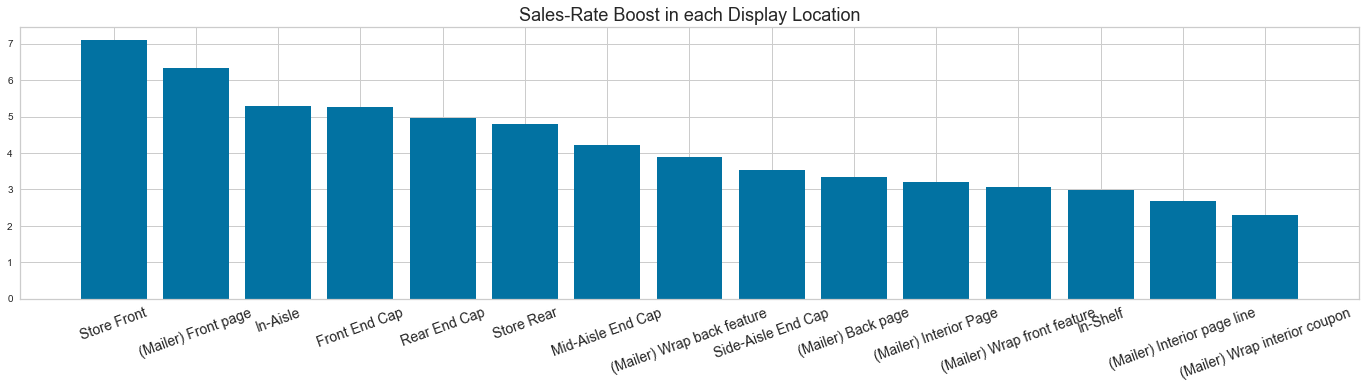

In [3471]:
salesRatesByDisplay.sort(key = lambda x: x[1], reverse = True) # sort for display 
fig, ax = plt.subplots(1,1,figsize = (24,5))
plt.bar(x = [display_location_dict[s] for (s, val) in salesRatesByDisplay], height = [x[1] for x in salesRatesByDisplay])
plt.xticks(rotation = 20, fontsize = 14)
plt.title("Sales-Rate Boost in each Display Location", fontsize = 18)
plt.show()

The bar plot above shows the multiplicative, average sales-rate boost for products, *while* being on display. We see that some display locations are drastically more effective than others, but that all are valuable for advertising. The best locations for advertising are in the store front (with a massive 7 times increase in sales), or on the front page of the weekly mailer. The lowest value advertising locations are in other locations in the weekly mailer, though they still enjoy a sizable sales boost factor between 2 and 3. 

The retailer can use the relative boosts in sales to help price advertising fees for different locations. 

In [3474]:
# What are the effects of featuring a product multiple times? 

# Create 'causal_df' to contain needed information on displays of (product, store)'s, including those that are featured *more than once*
# Keep products featured in ONE display location (in a given week)
causal_df = df["causal_data"].loc[(df["causal_data"].display == '0') | (df["causal_data"].mailer == '0')].copy()

# Create new column called "display_mailer" which combines "display" and "mailer" columns
causal_df["display_mailer"] = causal_df["display"] + causal_df["mailer"]

# Delete (p,s) displayed in more than one way
causal_df = causal_df.merge(
    causal_df.groupby(["PRODUCT_ID", "STORE_ID"]).display_mailer.nunique().rename("NumDisplayLocations"),
    on = ["PRODUCT_ID", "STORE_ID"],
    how = "left")
causal_df = causal_df[causal_df.NumDisplayLocations == 1]

# Drop unnecessary columns 
causal_df.drop(["display", "mailer", "NumDisplayLocations"], axis = 1, inplace = True)

# Keep only the data occurring at or after week 16
causal_df = causal_df[causal_df.WEEK_NO >= min_week].copy()

# Count number of featurings of (product, store)
causal_df["Count_Displays"] = causal_df.groupby(["PRODUCT_ID", "STORE_ID"]).WEEK_NO.rank()

In [3475]:
# Create new dataframe 'transactions_displayed': each row refers to another transaction of a (product, store) that was featured at ANY time
transactions_displayed = df["transaction_data"][["PRODUCT_ID", "STORE_ID", "WEEK_NO"]].rename({"WEEK_NO": "TRANSACTION_WEEK_NO"}, axis = 1)

# Throw out all data for transactions occuring <= week 15. 
transactions_displayed = transactions_displayed[transactions_displayed["TRANSACTION_WEEK_NO"] >= min_week]

# Inner join with information on when (product, store) was featured.
first_week_featured = causal_df.groupby(["PRODUCT_ID", "STORE_ID"]).WEEK_NO.min()
transactions_displayed = transactions_displayed.merge(first_week_featured.rename("FIRST_WEEK_FEATURED"), on = ["PRODUCT_ID", "STORE_ID"], how = "inner")

# Create new column, "WEEKS_BEFORE", with number of weeks during which data was being taken, BEFORE a (product, store) is featured.
transactions_displayed["WEEKS_BEFORE"] = transactions_displayed.FIRST_WEEK_FEATURED - min_week 

# Number of weeks between first week featured, and transaction 
transactions_displayed["WEEK_DIFFERENCE_FIRST"] = transactions_displayed.apply(
        lambda row: (row["TRANSACTION_WEEK_NO"] - row["FIRST_WEEK_FEATURED"]) if (row["TRANSACTION_WEEK_NO"] >= row["FIRST_WEEK_FEATURED"]) else -1, axis = 1)

In [3485]:
# Of (p,s) bought before first featuring: how many times sold?
sales_before = transactions_displayed[transactions_displayed.TRANSACTION_WEEK_NO < transactions_displayed.FIRST_WEEK_FEATURED]\
    .groupby(["PRODUCT_ID", "STORE_ID"]).size().rename("NumSalesBefore").to_frame()\
    .merge(transactions_displayed.groupby(["PRODUCT_ID", "STORE_ID"]).WEEKS_BEFORE.first(), on = ["PRODUCT_ID", "STORE_ID"], how = "left")
RateInitialUncorrected = (sales_before.NumSalesBefore / sales_before.WEEKS_BEFORE).mean()

# How many total (p,s) were ever featured? Includes those that were sold at *any* time. 
num_counted = sales_before.shape[0]
num_total = transactions_displayed.groupby(["PRODUCT_ID", "STORE_ID"]).size().shape[0]

RateInitial = RateInitialUncorrected * num_counted / num_total

# Sales rate boost for each week of featuring 
salesRates = []
feature_lim = 15
for feature_no in range(1, feature_lim + 1): 
    num_ps = causal_df[causal_df.Count_Displays == feature_no].merge(transactions_displayed, on = ["PRODUCT_ID", "STORE_ID"], how = "inner")\
        .groupby(["PRODUCT_ID", "STORE_ID"]).size().shape[0]
    num_sales = causal_df[causal_df.Count_Displays == feature_no].merge(transactions_displayed.rename({"TRANSACTION_WEEK_NO": "WEEK_NO"}, axis = 1), 
                    on = ["PRODUCT_ID", "STORE_ID", "WEEK_NO"], how = "inner").shape[0]
    salesRates.append(num_sales / num_ps)

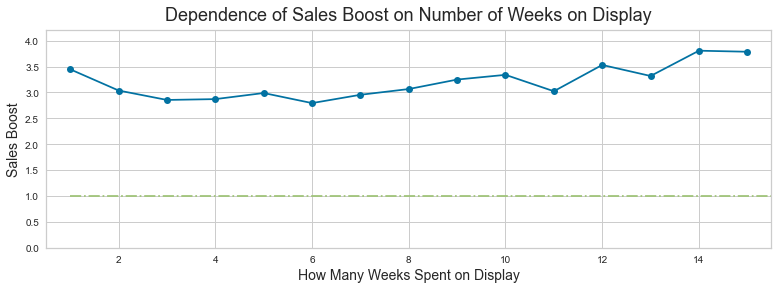

In [3487]:
fig, ax = plt.subplots(1,1,figsize = (13,4))
plt.plot(range(1, feature_lim + 1), np.array(salesRates / RateInitial), '-o')
plt.plot(range(1, feature_lim + 1 + 1), [1] * (feature_lim + 1), '-.')
plt.xlim(0.5,feature_lim + 0.5)
plt.ylim(0, 4.2)
plt.title("Dependence of Sales Boost on Number of Weeks on Display", fontsize = 18, pad = 10)
plt.xlabel("How Many Weeks Spent on Display", fontsize = 14)
plt.ylabel("Sales Boost", fontsize = 14)
plt.show()

The plot above depicts the average, multiplicative sales boost for a product that is continuously featured in-store or in-mailer for multiple weeks. We see that the effect is incredibly steady, without much increase or decrease! So featuring a product for multiple consecutive weeks does not cause increasing product-recognition and purchases. It also does not drop, indicating that customers do not grow fatigued by the display and start ignoring it. The latter result is encouraging; if a manufacturer wants to keep their sales rates elevated, it is worthwile for them to continuously advertise their products to be placed on display week after week. 